# Extra Project Logistic Regression:

### Motivation 
In this scenario, assume that our company recently released a new app and is investigating ways to promote it. We have the ability to send notifications to our users through their web browser and are investigating if sending notifications promoting the new app is a good way to spread the word. For evaluation, we performed a test in which we sent such notifications to a small subset of users. We now want to know if we should send out such notifications to all other users as well. 

### Description 
Users were selected randomly to either take part (1%) or to not take part (99%) in the test. Once selected, we sent one of three promoting notifications to the user with equal probability. The notification then was displayed to the user using different display mechanisms depending on the browser. Notifications 0, 1 and 2 were crafted with different wording, but all three contained a link the user could click to be redirected to our website. These notifications were then translated to all relevant languages, and the language of the browser determined in which language the notification was shown. 

The data sample provided with this case is completely fictional and already preprocessed.

The data is provided in two tables. In these tables you will find (fictional) data extracted from the server logs. Each line in the table “logs_notifications” corresponds to a request from the extension where it downloads the notifications. Each line in table “logs_web” corresponds to a request from the user when the link included in the notifications was clicked. The columns are: 

* Browser: Firefox or Chrome  
* The date and time of the request. (Format: YYYY-MM-DD hh:mm:ss)  
* The user’s IP address , in anonymised form.  
* The language of the delivered notification. (cn, de, en, es, fr, ru)  
* The number of the delivered notification. (0, 1 or 2)  

### Example 
A German user of Browser Chrome is selected to be shown notification number 2 on Sep 1st shortly after 11 o’clock. The corresponding log entry in “logs_notifications.csv” looks as follows: 

“chrome”, “2015-09-01 11:01:04”, “516e99d0e150152f94bd1443a679ca17”, “de”, “2” 

If the user decides to click the included link a while later, there will be another log entry in “logs_web.csv”:

“chrome”, “2015-09-01 11:02:17”, “516e99d0e150152f94bd1443a679ca17”, “de”, “2” 

### Tasks 
Assess the performances of messages 0, 1 and 2. Which one should we use if we send notifications to all users?

Our translation manager thinks that one or several of the translations are crappy and look like a 4-year old could have written that. Can you confirm that? 

Our designer is interested if there are differences between browsers, because the mechanisms for displaying notifications for these differ. 

### Bonus:
The Head of Business Development wants to decide if we actually should send out notifications to all users. He expects that one million or more installations should be worth it. Estimate the number of installations if we send out notifications to all users (assume that 50% of users that click the link included in the notifications will install the new app). 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Open and read the csv files:

# Each line in the table “logs_notifications” corresponds to a request from the extension where it downloads the notifications.
notifications = pd.read_csv('/Users/SaslowKa/Documents/logs_notifications.csv')
notifications

,browser,datetime,ip_anonymized,language,message
0,firefox,2015-09-01 00:00:00,d588180c3e5c462692c24cffd961de43,ru,2
1,chrome,2015-09-01 00:00:00,330f85e852916008aa80feb339696b2e,cn,0
2,chrome,2015-09-01 00:00:00,b85871b1112cde31be2864927c035ae3,fr,0
3,chrome,2015-09-01 00:00:00,51178bbf1c09a9a709b719fe948b5bd2,en,2
4,firefox,2015-09-01 00:00:01,884eec370b6d6bdf20d625039b9a3e8b,en,1
...,...,...,...,...,...
499995,chrome,2015-09-07 23:59:47,610e9adf09f64640e5715b3cdc5dc651,fr,0
499996,chrome,2015-09-07 23:59:49,62143d060d661e4c4032572207af3007,fr,0
499997,chrome,2015-09-07 23:59:50,3c84701f20eeadf652e9cb9ee25677eb,en,1
499998,chrome,2015-09-07 23:59:53,0e27bc5703ed5d0fd73f22c790368449,en,2


In [3]:
# Each line in table “logs_web” corresponds to a request from the user when the link included in the notifications was clicked.

clicks = pd.read_csv('/Users/SaslowKa/Documents/logs_web.csv')
clicks

,browser,datetime,ip_anonymized,language,message
0,chrome,2015-09-01 00:02:14,9631420eea21b0458d01f7cc598c3ac2,en,0
1,firefox,2015-09-01 00:04:25,08bd4c63e1abb0e624cde4ac1518de73,ru,2
2,firefox,2015-09-01 00:07:34,07678caba7be8bbadead98d5b530c5ff,de,1
3,chrome,2015-09-01 00:07:47,ba759e7216a6a73d55591aed389ce2ad,en,2
4,chrome,2015-09-01 00:08:41,db166a3780720484f9ca31b093c5b6f0,en,1
...,...,...,...,...,...
6433,firefox,2015-09-07 23:50:47,d2c77d1d3a091fb9ba3b2d32db4444d0,en,2
6434,chrome,2015-09-08 00:07:40,2c6727b05ab7e1eaa2e407ccc08fbde5,en,0
6435,chrome,2015-09-08 00:18:11,be2f0166a60ef72a41a6a406903241d2,cn,2
6436,chrome,2015-09-08 00:19:58,4b2a1f837fa81e90f7e43f82a18ad378,en,1


In [4]:
# merge the dataframes to begin to analyze the success of the different notifications in terms of getting clicks from users.

notifications.shape

(500000, 5)

In [5]:
clicks.shape

(6438, 5)

In [6]:
# for understanding: it seems that all the records in the notifications df are 100% of the browser's attempts to get a user to interact with a link
# and the records in the clicks df are all the successes (where a user clicks on the link.)

# since the columns are identical, you can merge them pretty easily. 

df = pd.merge(notifications, clicks, on=['ip_anonymized','browser','language','message'], how='left')
df

# pd.merge(ntf,web,on="ip_anonymized",how="left") code from Caner
# add a list of variables to the "on" arguement to include language, message, browser,. Data/time is the only varying variable

,browser,datetime_x,ip_anonymized,language,message,datetime_y
0,firefox,2015-09-01 00:00:00,d588180c3e5c462692c24cffd961de43,ru,2,NaN
1,chrome,2015-09-01 00:00:00,330f85e852916008aa80feb339696b2e,cn,0,NaN
2,chrome,2015-09-01 00:00:00,b85871b1112cde31be2864927c035ae3,fr,0,NaN
3,chrome,2015-09-01 00:00:00,51178bbf1c09a9a709b719fe948b5bd2,en,2,NaN
4,firefox,2015-09-01 00:00:01,884eec370b6d6bdf20d625039b9a3e8b,en,1,NaN
...,...,...,...,...,...,...
499995,chrome,2015-09-07 23:59:47,610e9adf09f64640e5715b3cdc5dc651,fr,0,NaN
499996,chrome,2015-09-07 23:59:49,62143d060d661e4c4032572207af3007,fr,0,NaN
499997,chrome,2015-09-07 23:59:50,3c84701f20eeadf652e9cb9ee25677eb,en,1,NaN
499998,chrome,2015-09-07 23:59:53,0e27bc5703ed5d0fd73f22c790368449,en,2,NaN


In [7]:
'''
looks like all of my datetime_y come from the clicks (or successes) dataframe, because there will be about 494,000 empty values
filter the dataframe for datetime_y.notnull() to see where all the clicks occured!
'''

'\nlooks like all of my datetime_y come from the clicks (or successes) dataframe, because there will be about 494,000 empty values\nfilter the dataframe for datetime_y.notnull() to see where all the clicks occured!\n'

In [8]:
df.dtypes

browser          object
datetime_x       object
ip_anonymized    object
language         object
message           int64
datetime_y       object
dtype: object

### Analysis

To see which of the messages are the most successful, it would make sense to look at the most common message type in the clicks df, 
then compare the failures (e.g. messages in notifications df that do not generate a new datapoint in the clicks df!)

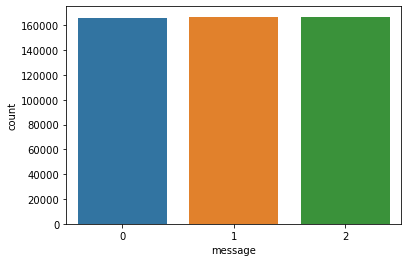

In [18]:
sns.countplot(x='message', data=df)
# the distribution of the message type is the same. Now compare the failures and successes of each message type!

In [10]:
# clicks.groupby?

In [11]:
# clicks.pivot_table?

In [33]:
# create a binary variable where 1 = notifcation led to click (e.g. presence of datetime_y value)
# and 0 = where notifaction did not generate a click.

df['user_click'] = np.where(df['datetime_y'].isnull()==True, 0, 1)
df['user_click'].value_counts() # make sure it works

0    493616
1      6384
Name: user_click, dtype: int64

In [ ]:
# rather than subsetting, just create dummy with message
# output variable = user_click (with logistic regression, it checks if it is 0 or 1).

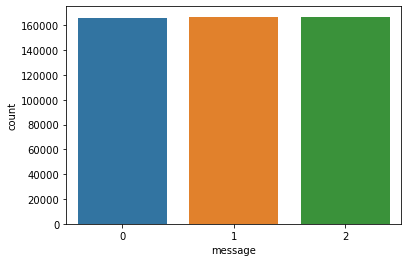

In [28]:
sns.countplot(x='message', data=df)

In [49]:
success = df[df['user_click']==1]
success

# subset to do another countplot with just the count of the SUCCESSFUL messages

,browser,datetime_x,ip_anonymized,language,message,datetime_y,user_click,0,1,2
112,chrome,2015-09-01 00:00:42,3320c458249f0d337a5f3adf53f25f88,en,1,2015-09-01 00:35:21,1,0,1,0
156,chrome,2015-09-01 00:00:59,db166a3780720484f9ca31b093c5b6f0,en,1,2015-09-01 00:08:41,1,0,1,0
260,chrome,2015-09-01 00:01:39,9631420eea21b0458d01f7cc598c3ac2,en,0,2015-09-01 00:02:14,1,1,0,0
279,firefox,2015-09-01 00:01:52,08bd4c63e1abb0e624cde4ac1518de73,ru,2,2015-09-01 00:04:25,1,0,0,1
510,chrome,2015-09-01 00:03:35,7776a44ddd857b364b58b99d2d620579,de,2,2015-09-01 00:42:17,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
498809,chrome,2015-09-07 22:31:38,b4d31a50b6284cf3ce54e31546c3d1eb,en,1,2015-09-07 22:32:10,1,0,1,0
498837,firefox,2015-09-07 22:33:59,3f0c9114cdd467d38e7605309d1caaea,en,1,2015-09-07 23:12:45,1,0,1,0
499095,chrome,2015-09-07 22:52:56,cda03402182f6a466572de44b82d621f,fr,2,2015-09-07 22:53:17,1,0,0,1
499527,chrome,2015-09-07 23:24:46,174751b793923b5d5a1d833dfef128aa,de,2,2015-09-07 23:28:23,1,0,0,1


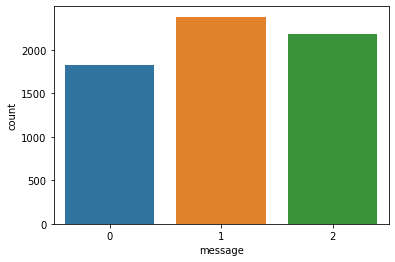

In [50]:
sns.countplot(x='message', data=success)

After subsetting for the success, you can start to compare how successful the languages, browers, messages, etc. were!

In [39]:
# before running regression, add dummy variables to the df (pd.merge, see code from Caner below). 

# add dummies into df

df[["0","1","2"]] = pd.get_dummies(df["message"])
# X = df[["0","2"]]
df

,browser,datetime_x,ip_anonymized,language,message,datetime_y,user_click,0,1,2
0,firefox,2015-09-01 00:00:00,d588180c3e5c462692c24cffd961de43,ru,2,NaN,0,0,0,1
1,chrome,2015-09-01 00:00:00,330f85e852916008aa80feb339696b2e,cn,0,NaN,0,1,0,0
2,chrome,2015-09-01 00:00:00,b85871b1112cde31be2864927c035ae3,fr,0,NaN,0,1,0,0
3,chrome,2015-09-01 00:00:00,51178bbf1c09a9a709b719fe948b5bd2,en,2,NaN,0,0,0,1
4,firefox,2015-09-01 00:00:01,884eec370b6d6bdf20d625039b9a3e8b,en,1,NaN,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
499995,chrome,2015-09-07 23:59:47,610e9adf09f64640e5715b3cdc5dc651,fr,0,NaN,0,1,0,0
499996,chrome,2015-09-07 23:59:49,62143d060d661e4c4032572207af3007,fr,0,NaN,0,1,0,0
499997,chrome,2015-09-07 23:59:50,3c84701f20eeadf652e9cb9ee25677eb,en,1,NaN,0,0,1,0
499998,chrome,2015-09-07 23:59:53,0e27bc5703ed5d0fd73f22c790368449,en,2,NaN,0,0,0,1


In [40]:
X = X = df[["0","2"]]
Y = df['user_click']
X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
results.summary()

# it appears that message 1 is more successful in generating a user_click as compared to messages 0 and 2.

Optimization terminated successfully.
         Current function value: 0.068291
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             user_click   No. Observations:               500000
Model:                          Logit   Df Residuals:                   499997
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                0.001078
Time:                        17:09:28   Log-Likelihood:                -34146.
converged:                       True   LL-Null:                       -34183.
Covariance Type:            nonrobust   LLR p-value:                 1.001e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2369      0.021   -205.219      0.000      -4.277      -4.196
0             -0.2643      0.031     -8.439      0.000      -0.326      -0.203
2             -0.0871      0.030     -2.918      0.004      -0.146      -0.029
==============================================================================
"""

In [ ]:
# change matrix to test. Set everybody's message to 1 (the best performing) and see what happens. 

In [52]:
pd.crosstab?